## 基于决策树原理的纯python实现

In [1]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from math import log
import operator
import pickle

In [2]:
#计算香农熵
def cal_shanno_entropy(dataset):
    num_samples=len(dataset)#获取样本长度
    label_count={}#分类标签计数
    for feat_vector in dataset:
        cur_label=feat_vector[-1]#获取每个记录的最后一个值，即分类标签
        if cur_label not in label_count.keys():
            label_count[cur_label]=0
        label_count[cur_label]+=1
    shanno_entropy=0.0 #初始化香农熵值
    for key in label_count:
        prob=float(label_count[key])/num_samples #计算每个分类标签出现的概率
        shanno_entropy-=prob*log(prob,2)#香农熵计算公式
    return shanno_entropy    

In [3]:
#创建数据集
def create_dataset():
    dataset=[[0, 0, 0, 0, 'no'],  
          [0, 0, 0, 1, 'no'],
          [0, 1, 0, 1, 'yes'],
          [0, 1, 1, 0, 'yes'],
          [0, 0, 0, 0, 'no'],
          [1, 0, 0, 0, 'no'],
          [1, 0, 0, 1, 'no'],
          [1, 1, 1, 1, 'yes'],
          [1, 0, 1, 2, 'yes'],
          [1, 0, 1, 2, 'yes'],
          [2, 0, 1, 2, 'yes'],
          [2, 0, 1, 1, 'yes'],
          [2, 1, 0, 1, 'yes'],
          [2, 1, 0, 2, 'yes'],
          [2, 0, 0, 0, 'no']]
    labels=["年龄","有工作","有自己的房子","信贷情况"]
    return dataset,labels

In [4]:
#按照给定特征划分数据集
def split_dataset(dataset,col,value):
    splited_dataset=[] #初始化切分后的数据集
    for feat_vector in dataset: #遍历数据集每行记录
        if feat_vector[col]==value:
            delete_col=feat_vector[:col] #将被切分的特征设置为右边界，意味着删除地col列
            delete_col.extend(feat_vector[col+1:])#将被删除列右侧的数据补上
            splited_dataset.append(delete_col)#将每行记录添加到被分割的数据集列表
    return splited_dataset        
            

In [5]:
#依据信息增益寻找最优划分的特征
def find_best_feature_to_split(dataset):
    num_feats=len(dataset[0])-1 #特征个数为特征向量长度减去最后一位的分类标签
    label_shanno=cal_shanno_entropy(dataset)#计算分类标签的熵值
    best_info_gain=0.0 #初始化最大的信息增益
    best_feat_idx=-1 #初始化最优分割特征索引
    
    for col in range(num_feats):#遍历所有特征
        feat_col=[feat_vector[col] for feat_vector in dataset]#将每个特征列取出
        unique_val=set(feat_col)#获取每列特征的不同值
        feat_entropy=0.0#初始化特征的信息熵
        for val in unique_val:
            sub_dataset=split_dataset(dataset,col,val)#计算每个特征按照各自不同值划分的数据子集
            prob_sub_dataset=len(sub_dataset)/float(len(dataset))#计算数据子集概率
            feat_entropy+=prob_sub_dataset*cal_shanno_entropy(sub_dataset)#将各个特征依照不同值切分的数据集计算信息熵并且加总
        info_gain=label_shanno-feat_entropy#信息增益计算
        
        if info_gain>best_info_gain: #判断是否为最大信息增益
            best_info_gain=info_gain#不是则更新最大信息增益值
            best_feat_idx=col#更新最优划分特征索引即信息增益最大 并返回
   
    return best_feat_idx         

In [6]:
#当特征划分到只有一个，但依然无法分类时，意味着树继续生长，采用最大投票法，选择最多类别作为该类标签

def max_vote_method(cate_labels):
    cate_label_count={}#计数每个类别标签
    for vote in cate_labels:
        if vote not in cate_label_count.keys():
            cate_label_count[vote]=0 #不存在则置0
        cate_label_count[vote]+=1#出现则加1
    sorted_label_count=sorted(cate_label_count.items(),key=operator.itemgetter(1),reverse=True)    #根据出现次数排序，返回cate_label_count出现次数最多的类别
    return sorted_label_count[0][0]

In [19]:
##决策树 核心程序

def create_Tree(dataset,feat_labels,best_feat_labels):
    cate_labels=[feat_vector[-1] for feat_vector in dataset]#获取每个特征向量最后的分类标签值
    if cate_labels.count(cate_labels[0])==len(cate_labels):#判断是否都为同一类
        return cate_labels[0]
    if len(dataset[0])==1:#遍历所有特征，返回出现次数最多的类标签
        return max_vote_method(cate_labels)
    best_feat=find_best_feature_to_split(dataset)#选择最优特征
    best_feat_label=feat_labels[best_feat]#获得最优特征的标签
    best_feat_labels.append(best_feat_label)
    Tree={best_feat_label:{}}#根据最优特征的标签生成树
    del feat_labels[best_feat]#删除已经使用的特征标签
    feat_vals=[feat_vect[best_feat] for feat_vect in dataset]#获取最优特征列的全部数据
    unique_vals=set(feat_vals)#去重
    
    for val in unique_vals:#遍历全部特征的所有不同取值
        Tree[best_feat_label][val]=create_Tree(split_dataset(dataset,best_feat,val),feat_labels,best_feat_labels)
        #递归创建决策树
    return Tree
    

In [8]:
#获取决策树叶子节点数目
def get_leaf_nums(Tree):
    num_leafs=0#初始化叶子
    first_level=next(iter(Tree))#第一层根节点
    second_dict=Tree[first_level]#获取根节点下数据
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=="dict":#判断是否为叶子节点，若为叶子节点，则类型不为dict
            num_leafs+=get_leaf_nums(second_dict[key])#递归，直到找到叶子节点
        else:
            num_leafs+=1 #判断为否时，意味着是叶子节点，则数量加1
    return num_leafs        

In [9]:
#获取决策树层数
def get_max_depth(Tree):
    max_depth=0#初始化最大深度
    first_level=next(iter(Tree))
    second_dict=Tree[first_level]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=="dict":
            cur_depth=1+get_max_depth(second_dict[key])#递归直到找到最后的叶子节点
        else:
            cur_depth=1#找到叶子节点时当前深度加1
        if cur_depth>max_depth:#判断当前深度是否为最大深度
            max_depth=cur_depth#若是则更新当前深度为最大深度
    return max_depth        

In [10]:
#绘制节点

def plot_Node(node_name,center_posit,parent_posit,node_type):
    arrow_args=dict(arrowstyle="<-")
    font=FontProperties(fname=r"C:\windows\fonts\simsun.ttc",size=14)
    build_plot_pannel.ax1.annotate(node_name,xy=parent_posit,xycoords="axes fraction",xytext=center_posit,textcoords="axes fraction",va="center",ha="center",bbox=node_type,arrowprops=arrow_args,FontProperties=font)

In [11]:
#标注有向边属性值
def plot_mid_name(center_posit,parent_posit,node_text):
    x_mid=(parent_posit[0]-center_posit[0])/2.0+center_posit[0]
    y_mid=(parent_posit[1]-center_posit[1])/2.0+center_posit[1]
    build_plot_pannel.ax1.text(x_mid,y_mid,node_text,va="center",ha="center",rotation=30)

In [12]:
#绘制决策树
def plot_Tree(Tree,parent_posit,node_name):
    decision_node=dict(boxstyle="sawtooth",fc="0.8")
    leaf_node=dict(boxstyle="round4",fc="0.8")
    num_leafs=get_leaf_nums(Tree)
    depth=get_max_depth(Tree)
    
    first_level=next(iter(Tree))
    center_posit=(plot_Tree.xOff+(1.0+float(num_leafs))/2.0/plot_Tree.totalW,plot_Tree.yOff)
    plot_mid_name(center_posit,parent_posit,node_name)
    plot_Node(first_level,center_posit,parent_posit,decision_node)
    second_dict=Tree[first_level]
    plot_Tree.yOff=plot_Tree.yOff-1.0/plot_Tree.totalD
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=="dict":
            plot_Tree(second_dict[key],center_posit,str(key))
        else:
            plot_Tree.xOff=plot_Tree.xOff+1.0/plot_Tree.totalW
            plot_Node(second_dict[key],(plot_Tree.xOff,plot_Tree.yOff),center_posit,leaf_node)
    
    plot_Tree.yOff=plot_Tree.yOff+1.0/plot_Tree.totalD
    
    

In [13]:
#创建绘制面板
def build_plot_pannel(Tree):
    fig=plt.figure(1,facecolor="white")
    fig.clf()
    ax_prop=dict(xticks=[],yticks=[])
    build_plot_pannel.ax1=plt.subplot(111,frameon=False,**ax_prop)
    plot_Tree.totalW=float(get_leaf_nums(Tree))
    plot_Tree.totalD=float(get_max_depth(Tree))
    plot_Tree.xOff=-0.5/plot_Tree.totalW
    plot_Tree.yOff=1.0
    plot_Tree(Tree,(0.5,1.0),"")
    plt.show()

In [14]:
#使用决策树分类

def classifier(built_tree,best_feat_labels,test_X):
    first_level=next(iter(built_tree))
    second_dict=built_tree[first_level]
    feat_idx=best_feat_labels.index(first_level)#根节点的特征索引
    for key in second_dict.keys():#遍历第一个根节点下所有的特征
        if test_X[feat_idx]==key:#判断测试数据特征种类是否一致
            if type(second_dict[key]).__name__=="dict":#若当前节点下还有分裂可能则在更深处递归寻找与测试数据匹配的节点
                classify_res=classifier(second_dict[key],best_feat_labels,test_X)
            else:
                classify_res=second_dict[key]#返回当前叶子节点的类别作为分类结果
    return classify_res

In [15]:
#存储决策树

def save_Tree(built_tree,filename):
    with open(filename,"wb") as sT:
        pickle.dump(built_tree,sT)

In [16]:
#读取决策树
def read_Tree_file(filename):
    sT_read=open(filename,"rb")
    return pickle.load(sT_read)


最优特征索引:2
{'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}


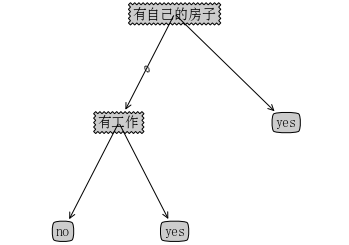

no
不放贷


In [20]:
if __name__=="__main__":
    dataset,labels=create_dataset()
    print("最优特征索引:"+str(find_best_feature_to_split(dataset)))
    best_feat_labels=[]
    Tree=create_Tree(dataset,labels,best_feat_labels)
    print(Tree)
    build_plot_pannel(Tree)
    test_X=[0,0,0,0]
    result=classifier(Tree,best_feat_labels,test_X)
    print(result)
    if result=="yes":
        print("放贷")
    if result=="no":
        print("不放贷")
        


## 使用sklearn的decision tree实现

In [21]:
import pandas as pd
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.preprocessing import LabelEncoder

F:\Ana\Lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
#!pip install --user pydotplus

In [23]:
if __name__=="__main__":
    with open("lenses.txt","r") as fr:
        lenses=[line.strip().split("\t") for line in fr.readlines()]
    lenses_target=[]
    for feat_vect in lenses:
        lenses_target.append(feat_vect[-1])
    
    lenses_labels=["age","prescript","astigmatic","tearRate"]
    lenses_list=[]
    lenses_dict={}
    for feat_label in lenses_labels:
        for feat_vect in lenses:
            lenses_list.append(feat_vect[lenses_labels.index(feat_label)])
        lenses_dict[feat_label]=lenses_list
        lenses_list=[]
    lenses_df=pd.DataFrame(lenses_dict)
    
    label_encode=LabelEncoder()
    for col in lenses_df.columns:
        lenses_df[col]=label_encode.fit_transform(lenses_df[col])
    
    clf=tree.DecisionTreeClassifier(max_depth=4)
    clf=clf.fit(lenses_df.values.tolist(),lenses_target)
    
    dot1_data=StringIO()
    tree.export_graphviz(clf,out_file=dot1_data,feature_names=lenses_df.keys(),class_names=clf.classes_,filled=True,rounded=True,special_characters=True)
    
    graph=pydotplus.graph_from_dot_data(dot1_data.getvalue())
    graph.write_pdf("tree.pdf")
    print(clf.predict([[1,1,1,0]]))


['hard']
